In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class0_pathclass1_path
# Verificar contenido de las carpetas
def list_files_recursively(directory):
    files = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            file_path = os.path.join(root, filename)
            files.append(file_path)
    return files

class0_files = list_files_recursively(class0_path)
class1_files = list_files_recursively(class1_path)

print(f"Imágenes en clase 0: {len(class0_files)}")
print(f"Imágenes en clase 1: {len(class1_files)}")


Imágenes en clase 0: 3725
Imágenes en clase 1: 1889


In [3]:
# Dataset personalizado
class SARImageDataset(Dataset):
    def __init__(self, class0_dir, class1_dir, transform=None):
        self.class0_files = list_files_recursively(class0_dir)
        self.class1_files = list_files_recursively(class1_dir)
        self.files = self.class0_files + self.class1_files
        self.labels = [0] * len(self.class0_files) + [1] * len(self.class1_files)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]
        try:
            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
            return img, label
        except Exception as e:
            print(f"Error al procesar la imagen {img_path}: {e}")
            return None, None

In [4]:
# Transformaciones
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [5]:
# Crear dataset y dataloader
dataset = SARImageDataset(class0_path, class1_path, transform=transform)

# Dividir el dataset en entrenamiento, test y validación (80%, 10%, 10%)
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
valid_size = len(dataset) - train_size - test_size
train_dataset, test_dataset, valid_dataset = random_split(dataset, [train_size, test_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [6]:
# Definir la CNN básica
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

# Instanciar el modelo, definir pérdida y optimizador
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [7]:
# Función para calcular accuracy
def calculate_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Variables para almacenar las precisiones
train_accuracies = []
valid_accuracies = []
test_accuracies = []

Epoch 1/5: 100%|██████████| 141/141 [00:40<00:00,  3.47batch/s]


Epoch 1/5, Loss: 89.3125
Train Accuracy: 66.62% | Valid Accuracy: 66.55% | Test Accuracy: 63.99%


Epoch 2/5: 100%|██████████| 141/141 [00:40<00:00,  3.52batch/s]


Epoch 2/5, Loss: 88.4263
Train Accuracy: 66.62% | Valid Accuracy: 66.55% | Test Accuracy: 63.99%


Epoch 3/5: 100%|██████████| 141/141 [00:36<00:00,  3.82batch/s]


Epoch 3/5, Loss: 88.2750
Train Accuracy: 66.62% | Valid Accuracy: 66.55% | Test Accuracy: 63.99%


Epoch 4/5: 100%|██████████| 141/141 [00:36<00:00,  3.84batch/s]


Epoch 4/5, Loss: 87.9495
Train Accuracy: 66.62% | Valid Accuracy: 66.55% | Test Accuracy: 63.99%


Epoch 5/5: 100%|██████████| 141/141 [00:40<00:00,  3.52batch/s]


Epoch 5/5, Loss: 87.6417
Train Accuracy: 66.62% | Valid Accuracy: 66.55% | Test Accuracy: 63.99%


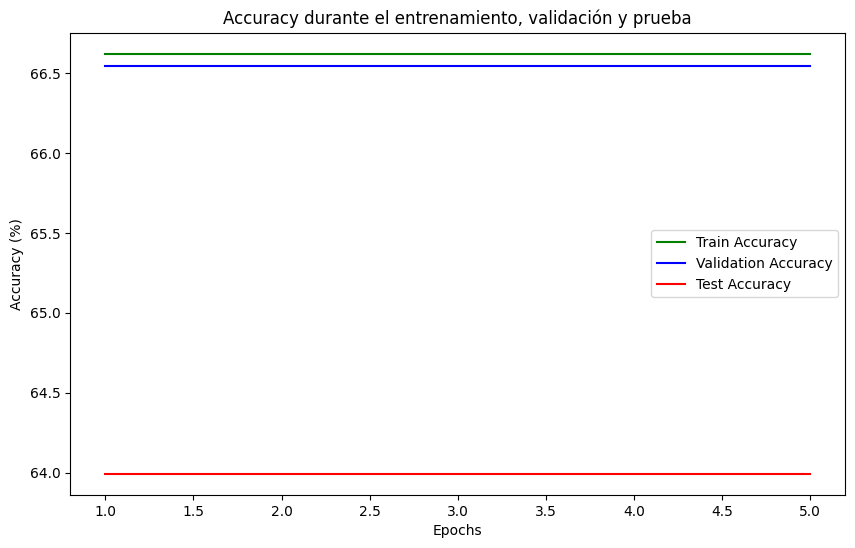

Entrenamiento completado.


In [8]:
# Entrenamiento con barra de progreso
epochs = 5  # Reducido para pruebas
for epoch in range(epochs):
    running_loss = 0.0
    # Crear la barra de progreso usando tqdm
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
        if images is None:  # Saltar imágenes con errores
            continue
        # Reiniciar gradientes
        optimizer.zero_grad()

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        # Acumular pérdida
        running_loss += loss.item()

    # Calcular accuracy en los datasets de train, valid y test
    train_accuracy = calculate_accuracy(train_loader)
    valid_accuracy = calculate_accuracy(valid_loader)
    test_accuracy = calculate_accuracy(test_loader)

    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.2f}% | Valid Accuracy: {valid_accuracy:.2f}% | Test Accuracy: {test_accuracy:.2f}%")

# Graficar las accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, epochs+1), valid_accuracies, label='Validation Accuracy', color='blue')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy durante el entrenamiento, validación y prueba')
plt.legend()
plt.show()

print("Entrenamiento completado.")

Accuracy: 63.99%
AUC: 0.6861


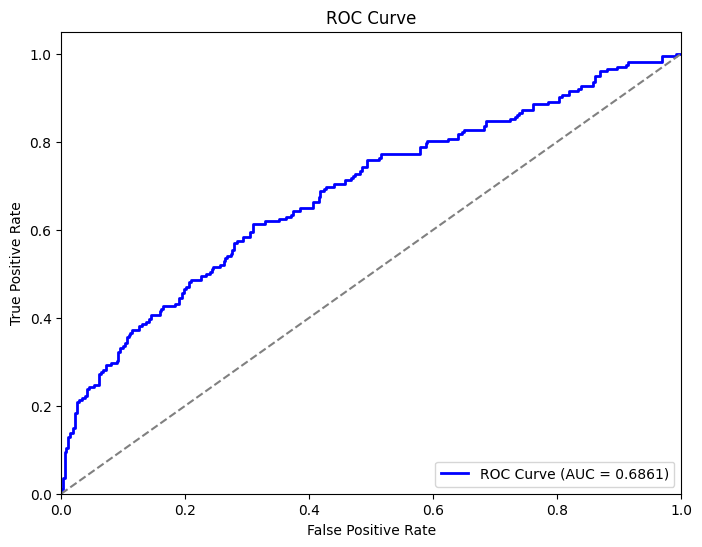

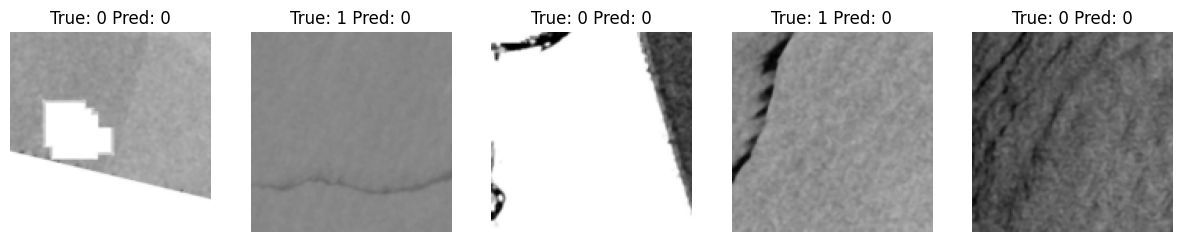

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score
import numpy as np
import torch
from tqdm import tqdm

# Función para evaluar el modelo
def evaluate_model(model, dataloader):
    model.eval()  # Establecer el modelo en modo evaluación
    
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for images, labels in dataloader:
            if images is None:  # Saltar imágenes con errores
                continue
            # Obtener las predicciones
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilidades de la clase 1

            # Guardar etiquetas y predicciones
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())
            all_probs.extend(probs.numpy())

    # Calcular Accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calcular Curva ROC y AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    auc_score = auc(fpr, tpr)
    
    return accuracy, fpr, tpr, auc_score, all_labels, all_preds

# Función para visualizar algunas imágenes y sus predicciones
def visualize_predictions(dataloader, model, num_images=5):
    model.eval()
    images, labels = next(iter(dataloader))
    
    # Realizar predicciones
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0))  # Convertir de [C, H, W] a [H, W, C]
        ax.set_title(f"True: {labels[i].item()} Pred: {preds[i].item()}")
        ax.axis('off')
    
    plt.show()

# Evaluar el modelo en el conjunto de test
accuracy, fpr, tpr, auc_score, all_labels, all_preds = evaluate_model(model, test_loader)

# Mostrar los resultados de Accuracy y AUC
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"AUC: {auc_score:.4f}")

# Graficar la Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Visualizar algunas imágenes con sus predicciones
visualize_predictions(test_loader, model, num_images=5)
